 ##  <center> Click on ad prediction ##

The dataset "dataset.csv" is a synthetic dataset created by some website. Each row represents a user and his/her features and whether He/She Clicked on some advertisement or closed It on that website at some time. The link of the dataset is : "https://www.kaggle.com/fayomi/advertising".
Our goal is to use the features in order to predict if a user would click on an advertisement.
Here is a description of the variables of the dataset :


|Variable                 | Signification                                        |
|-------------------------|------------------------------------------------------|
|Daily Time Spent on Site:|consumer time on site in minutes                      |
|Age:                     |cutomer age in years                                  |
|Area Income:             |Avg. Income of geographical area of consumer          |
|Daily Internet Usage:    | Avg. minutes a day consumer is on the internet       |
|Ad Topic Line:           | Headline of the advertisement                        |
|City:                    |City of consumer                                      |
|Male:                    |Whether or not consumer was male                      |
|Country:                 |Country of consumer                                   |
|Timestamp:               |Time at which consumer clicked on Ad or closed window |
|Clicked on Ad:           |0 or 1 indicated clicking on Ad                       |

Some useful imports

In [479]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.colors as pltcolors
from sklearn import linear_model, svm, discriminant_analysis, metrics
from scipy import optimize
import seaborn as sns

In [480]:
# import utils file 
import utils
#change according to the file location in your machine

We fix the random seed so as the results are reproduceable

In [481]:
import random

random.seed(10)
print(random.random())

0.5714025946899135


### I- Exploratory data analysis

In [482]:
data = pd.read_csv('C:\\Users\\salma\\Downloads\\advertising.csv',sep=',')

In [483]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [484]:
data.shape

(1000, 10)

In [485]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [486]:
data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


In [487]:
data['Clicked on Ad'].value_counts()

1    500
0    500
Name: Clicked on Ad, dtype: int64

The classes are well balanced

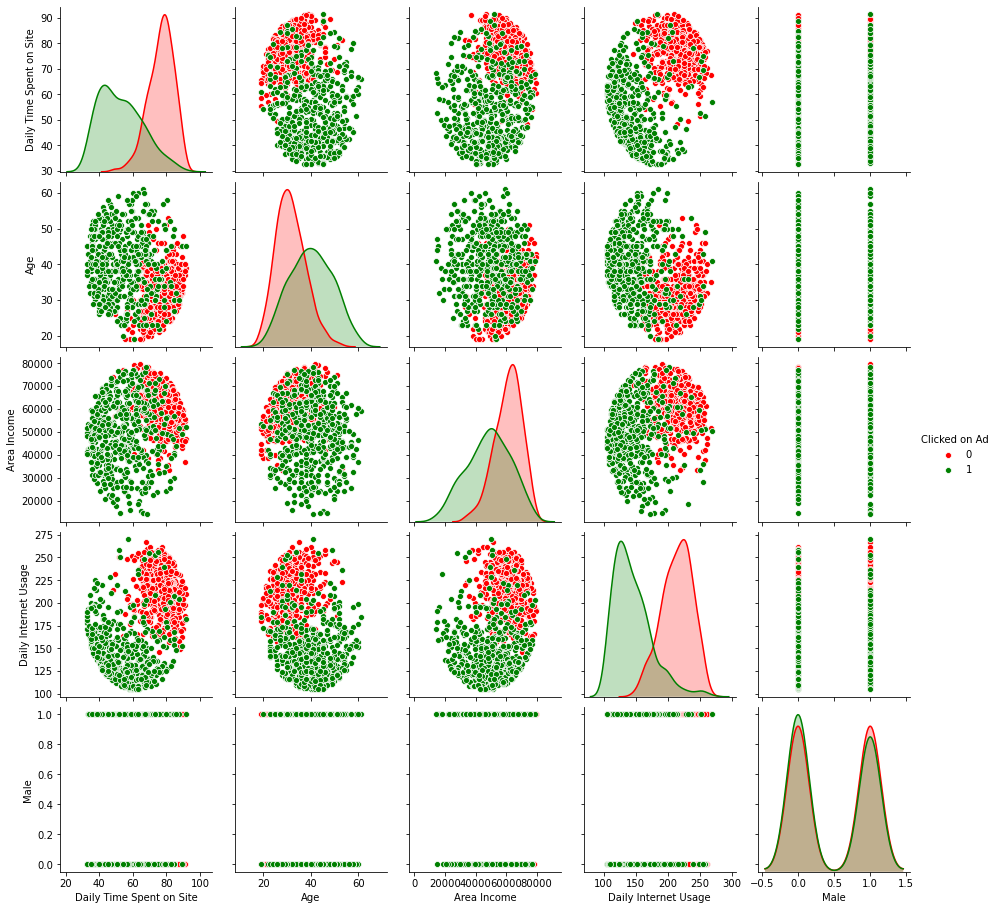

In [488]:
sns.pairplot(data, hue='Clicked on Ad', palette =['red','green'])
plt.show()

From the pairplot, we can observe : 
   + Users who do not click on ads are majoritarily young users (< 40)  ; The distribution of users who click on ads is centered on age 40 
   + The majority of users who do not click on ads belong to an area with high income
   + Users who click on ads mostly use internet less than users who do not click on ads
   + Users who click on ads mostly surf on the site less than users who do not click on ads

Split to train and test

In [489]:
data_copy = data.copy()
data_train = data.sample(n=900, random_state=1)
data_test = data_copy.drop(data_train.index)

Normalize train data

In [490]:
numerical_data = data_train[['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage','Male']]
A = numerical_data.values
numerical_data1 = data_test[['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage','Male']]
A1 = numerical_data1.values


In [491]:
mA = A.mean(axis=0)
sA = A.std(axis=0)
A = (A-mA)/sA
A1 = (A1-mA)/sA

In [492]:
y = data_train['Clicked on Ad'].values
y1 = data_test['Clicked on Ad'].values

Show correlation and Apply PCA 

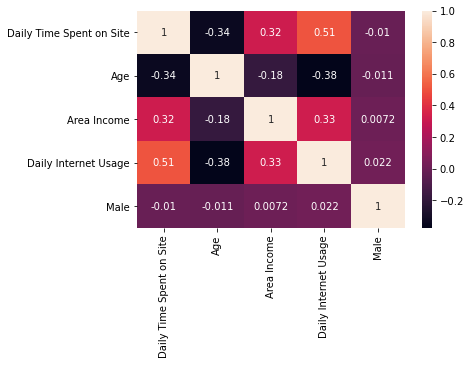

In [493]:
## Plot the correlation between numerical attributes

corrMatrix = numerical_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

According to the matrix of correlation, attributes are not highly correlated between them; but Daily Internet Usage is a bit strongly and positively correlated with daily time on site, then secondly comes the area income which is positively correlated with Daily Internet Usage as well as Daily time spent on site.

In [494]:
U, s, V = np.linalg.svd(A)
Ar = A.dot( V.transpose() )

Plot the sqrt of the eigen values

Text(0.5, 1.0, 'Square root of eignevalues of Atranspose*A')

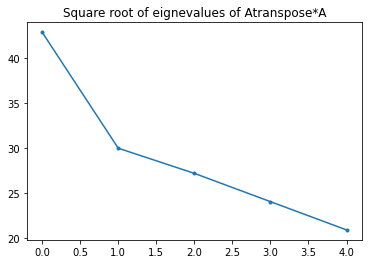

In [495]:
plt.plot(s, '.-')
plt.title('Square root of eignevalues of Atranspose*A')

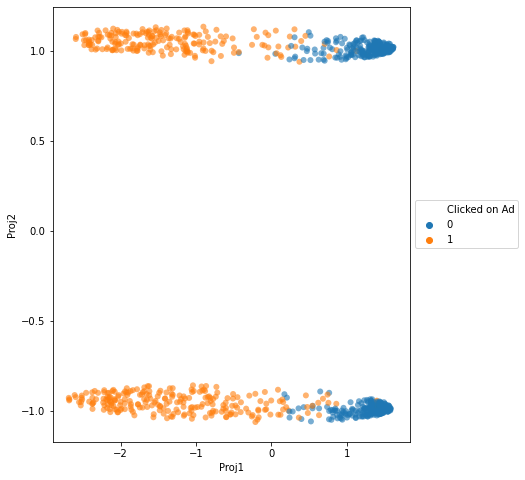

In [128]:
df = pd.DataFrame(Ar[:,0:2], columns=['Proj1', 'Proj2'])
df['Clicked on Ad'] = y
plt.figure(figsize=(8,8))
ax = sns.scatterplot('Proj1', 'Proj2', data=df,
              palette='tab10',
              hue='Clicked on Ad',
              linewidth=0,
              alpha=0.6
            )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Explained Variance : 

In [129]:
(np.cumsum(s**2)/np.sum(s**2)*100)[1]

60.88612730518821

3D plot 

In [130]:
(np.cumsum(s**2)/np.sum(s**2)*100)[2]

77.35739388523254

In [131]:
!pip install plotly
import plotly.express as px

In [132]:
transformed_encodings = pd.DataFrame(Ar[:,0:3], columns=[0, 1, 2])
transformed_encodings['Clicked on Ad'] = y
fig = px.scatter_3d(
  transformed_encodings, x=0, y=1, z=2, color=transformed_encodings['Clicked on Ad'],
  labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

As we can see in the 3D projection retrieved by PCA, the data is quite simple. It seems that the two classes are even almost linearly separable..

Problem setting

Given train data A  and train labels y, y being labels of examples in A , y $\in\$ {0,1} , We try to train a binary classification model h to map A to y. We are going to test the generalization capacity of the model h on test data A1 and test labels y1

In [133]:
y[y==0] = -1


## 1- LOGISTIC REGRESSION WITH FULL GRADIENT DESCENT - CONSTANT STEP SIZE: 

In [499]:
n = A.shape[0]

To ensure theoretically the converence, Stepsize should be chosen such as 
  $$\tau < \frac{2}{L}$$ where : <br>
 $L=\frac{\|A^T A\|}{4n}$ is a Lipschitz constant for $\nabla f$ when there is no regularization


In [500]:
n = A.shape[0]
L = np.linalg.norm(A, ord=2) ** 2 / (4. * n) 

tau_max = 2/L
print('tau_max',2/L)

tau_max 3.9150863405085414


In [501]:
tau = 1/(2*L)
niter = 80
lbda = 0
x,cost_values1,gd = gradient_descent(A,y,tau,niter,lbda)

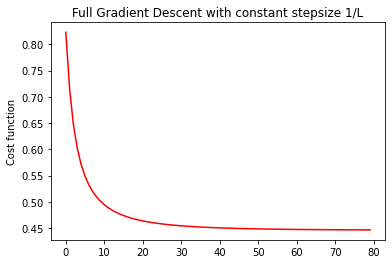

In [502]:
plt.plot(range(niter),cost_values1, color = 'red')
plt.title('Full Gradient Descent with constant stepsize 1/L')
plt.ylabel('Cost function')
plt.show()

The Gradient descent algorithm starts converging within 70 iterations

Let's check if the gradients are becoming close to 0 : 

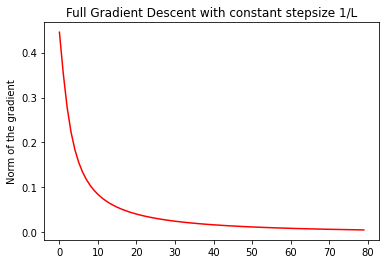

In [503]:
plt.plot(range(niter),gd, color = 'red')
plt.title('Full Gradient Descent with constant stepsize 1/L')
plt.ylabel('Norm of the gradient')
plt.show()

choice of different step sizes

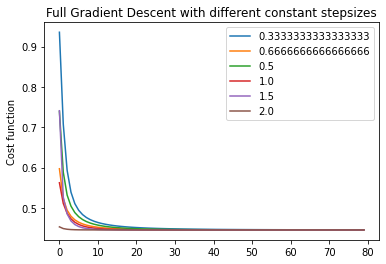

In [504]:
tau_values = [1/3 * tau_max, 2/3 * tau_max, tau_max/2, tau_max, 1.5* tau_max, 2* tau_max]
niter = 80
lbda = 0
for tau in tau_values :
    x,cost_values,_ = gradient_descent(A,y,tau,niter,lbda)
    plt.plot(range(niter),cost_values, label=str(tau/tau_max))
    plt.title('Full Gradient Descent with different constant stepsizes')
    plt.ylabel('Cost function')
    plt.legend()
plt.show()

this plot shows that as we increase the stepsize, the loss drops more rapidly. However, if we use a stepsize higher than tau_max = 2/L, we don't have theoretical garantees of convergence. In the case of this simple dataset, the algorithm still converges


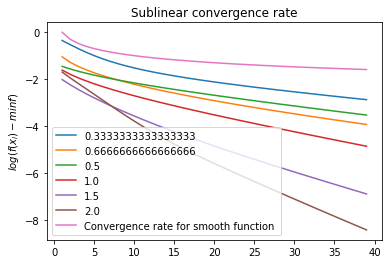

In [505]:


tau_values = [1/3 * tau_max, 2/3 * tau_max, tau_max/2, tau_max, 1.5* tau_max, 2* tau_max]
niter = 80
ndisp = int(niter/2)
lbda = 0
for tau in tau_values :
    x,cost_values,_ = gradient_descent(A,y,tau,niter,lbda)
    plt.plot(np.arange(1,ndisp), np.log10(cost_values[1:ndisp]-np.min(cost_values)), label=str(tau/tau_max))
    plt.title('Sublinear convergence rate')
    plt.ylabel('$log(f(x_l) - min f)$')
    plt.legend()
plt.plot(np.arange(1,ndisp),np.log10(1/np.arange(1,ndisp)),label = 'Convergence rate for smooth function ')
plt.legend()
plt.show()

We saw that logistic function is a smooth function but It's not strongly convex. So the convergence rate is shown to be of O(1/k).
The curves for tau<= tau_max are quite parallel to the line of the convergence rate..

## 2- LOGISTIC REGRESSION WITH FULL GRADIENT DESCENT - ACCELERATED STEP SIZE: 

Let's implement Nesterov Gradient acceleration. So as instead to have a convergence rate of 1/k , we will have 1/k². For this to be garanteed, we have to use a stepsize = 1/L

In [506]:
tau = 1/(L)
niter = 80
lbda = 0
x,cost_values2 = nesterov_gradient_descent(A,y,tau,niter,lbda)
x,cost_values3 = nesterov_gradient_descent(A,y,tau/2,niter,lbda)

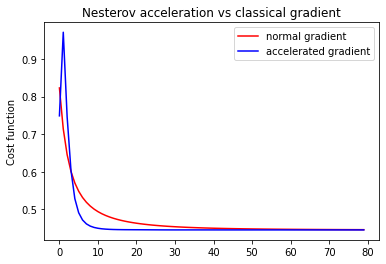

In [507]:
plt.plot(range(niter),cost_values1, color = 'red',label='normal gradient')
plt.plot(range(niter),cost_values2, color = 'blue',label='accelerated gradient')
plt.title('Nesterov acceleration vs classical gradient')
plt.ylabel('Cost function')
plt.legend()
plt.show()

As It is expected, the Nesterov algo converges faster than simple Gradient

Convergence rate

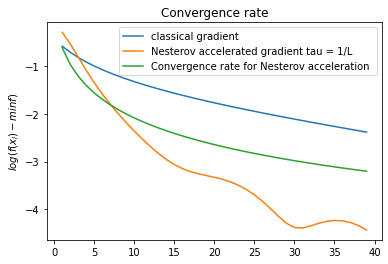

In [508]:
niter = 80
ndisp = int(niter/2)
lbda = 0
plt.plot(np.arange(1,ndisp), np.log10(cost_values1[1:ndisp]-np.min(cost_values1)), label='classical gradient')
plt.plot(np.arange(1,ndisp), np.log10(cost_values2[1:ndisp]-np.min(cost_values2)), label='Nesterov accelerated gradient tau = 1/L')
plt.plot(np.arange(1,ndisp),2*np.log10(1/(1+np.arange(1,ndisp))),label = 'Convergence rate for Nesterov acceleration ')

plt.title('Convergence rate')
plt.ylabel('$log(f(x_l) - min f)$')
plt.legend()
plt.show()

The convergence rate of Nesterov in log scale should be of O(2 log(1/k))

## 3- MINI-Batch gradient and stochastic gradient

In [509]:
tau = 1/(2*L)
nb_epochs = 30
lbda = 0
nb = 1
n = 900
n_iter=int(nb_epochs*n/nb)

x,cost_values,val_cost_values = stoch_grad(A,tau,y,lbda,nb, n_iter,scaling =0)

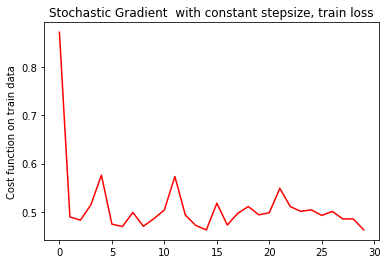

In [510]:
plt.plot(range(nb_epochs),cost_values, color = 'red')
plt.title('Stochastic Gradient  with constant stepsize, train loss')
plt.ylabel('Cost function on train data')
plt.show()

Impact of batch size on train loss :

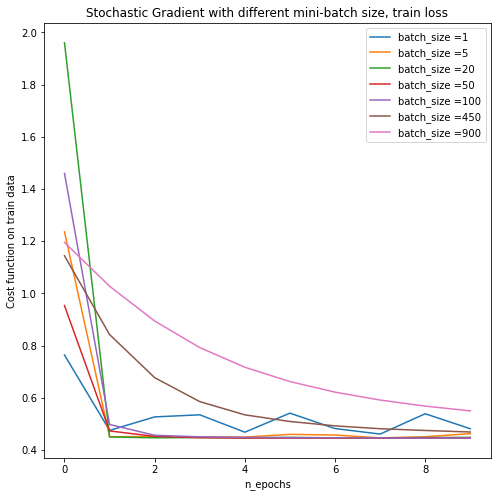

In [511]:
plt.figure(figsize = (8,8))
tau = 1/(2*L)
nb_epochs = 10
lbda = 0
nb = [1,5,20,50,100,450,900]

for size in nb : 

    niter = nb_epochs*n//size

    x,cost_values,val_cost_values = stoch_grad(A,tau,y,lbda,size, niter,scaling = 0)
    plt.plot(range(nb_epochs),cost_values, label = 'batch_size ='+str(size))
plt.title('Stochastic Gradient with different mini-batch size, train loss')
plt.ylabel('Cost function on train data')
plt.xlabel('n_epochs')
plt.legend()
plt.show()

Impact of batch size on validation loss

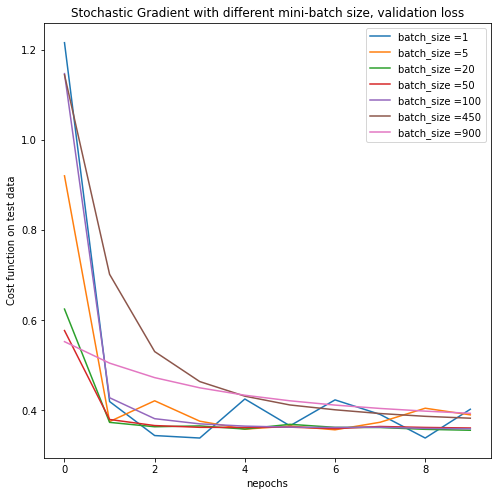

In [512]:
plt.figure(figsize = (8,8))
tau = 1/(2*L)
niter = 100
lbda = 0

for size in nb : 
    niter = nb_epochs*n//size
    x,cost_values,val_cost_values = stoch_grad(A,tau,y,lbda,size, niter,scaling = 0)
    plt.plot(range(nb_epochs),val_cost_values, label = 'batch_size ='+str(size))
plt.title('Stochastic Gradient with different mini-batch size, validation loss')
plt.ylabel('Cost function on test data')
plt.xlabel('nepochs')
plt.legend()
plt.show()

on the test set, mini batch algo with intermediate values of mini batch size have lower error than mini batch algo with very high batch size

Impact of learning rate on train loss :

In [515]:
tau_values = [tau_max, 1/2 *tau_max ,1/3 * tau_max, 1/5 * tau_max, 1/10 *tau_max,1/30*tau_max]


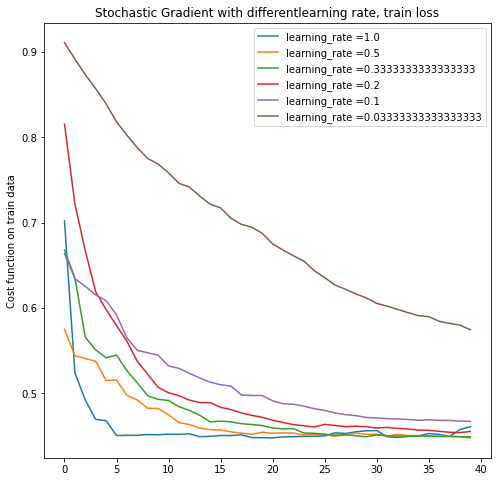

In [516]:
plt.figure(figsize = (8,8))


lbda = 0
size = 20
niter = 40
for tau in tau_values : 
    x,cost_values,val_cost_values = stoch_grad2(A,tau,y,lbda,size, niter)
    plt.plot(range(niter),cost_values, label = 'learning_rate ='+str(tau/tau_max))
plt.title('Stochastic Gradient with differentlearning rate, train loss')
plt.ylabel('Cost function on train data')
plt.legend()
plt.show()

Impact of learning rate on validation loss :

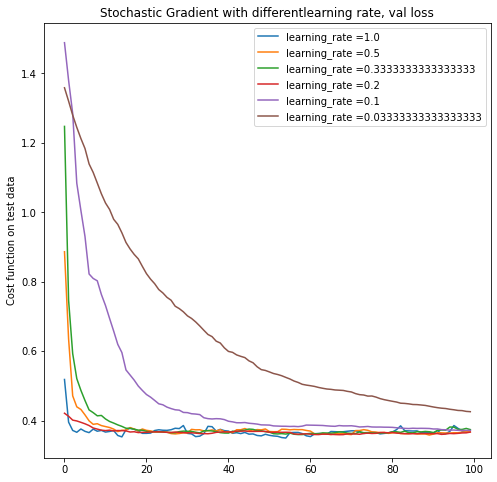

In [518]:
plt.figure(figsize = (8,8))

niter = 100
lbda = 0
size = 20
for tau in tau_values : 
    x,cost_values,val_cost_values = stoch_grad2(A,tau,y,lbda,size, niter)
    plt.plot(range(niter),val_cost_values, label = 'learning_rate ='+str(tau/tau_max))
plt.title('Stochastic Gradient with differentlearning rate, val loss')
plt.ylabel('Cost function on test data')
plt.legend()
plt.show()

We can see that for a low learning rate, the convergence is slow but for a large learning rate( $\tau <1/L$) the descent is fast.

Diagonal scaling

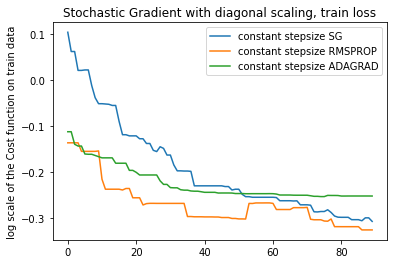

In [521]:

lbda = 0
size = 1
n_iter= 120
ndisp = 90

x,cost_values,val_cost_values = stoch_grad2(A,tau,y,lbda,size, niter = niter)
x_rmsprop,cost_values_rmsprop,val_cost_values_rmsprop = stoch_grad2(A,tau,y,lbda,size, niter = niter,scaling=1)
x_adagrad,cost_values_adagrad,val_cost_values_adagrad = stoch_grad2(A,tau,y,lbda,size, niter = niter,scaling=2)

plt.plot(np.arange(0,ndisp),np.log10(cost_values)[:ndisp],label = 'constant stepsize SG')
plt.plot(np.arange(0,ndisp),np.log10(cost_values_rmsprop)[:ndisp],label = 'constant stepsize RMSPROP')
plt.plot(np.arange(0,ndisp),np.log10(cost_values_adagrad)[:ndisp],label = 'constant stepsize ADAGRAD')

plt.title('Stochastic Gradient with diagonal scaling, train loss')
plt.ylabel('log scale of the Cost function on train data')
plt.legend()
plt.show()

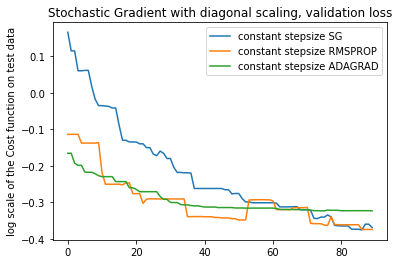

In [522]:
plt.plot(np.arange(0,ndisp),np.log10(val_cost_values)[:ndisp],label = 'constant stepsize SG')
plt.plot(np.arange(0,ndisp),np.log10(val_cost_values_rmsprop)[:ndisp],label = 'constant stepsize RMSPROP')
plt.plot(np.arange(0,ndisp),np.log10(val_cost_values_adagrad)[:ndisp],label = 'constant stepsize ADAGRAD')

plt.title('Stochastic Gradient with diagonal scaling, validation loss')
plt.ylabel('log scale of the Cost function on test data')
plt.legend()
plt.show()

## 4- Regularization

## LASSO

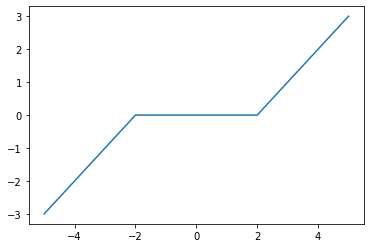

In [526]:
t = np.linspace(-5,5,201)
plt.clf
plt.plot(t,Soft(t,2)) 
plt.axis('tight');

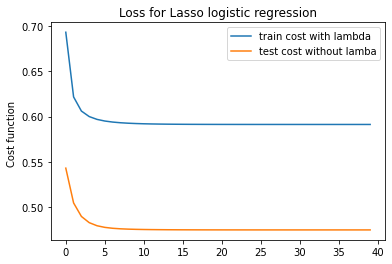

In [532]:
tau = tau_max/2
lbda = 0.05
d = A.shape[1]
niter = 40
flist, x,E_test = forward_backward(A,y,lbda,tau,d)

plt.plot(range(niter),flist,label ='train cost with lambda')
plt.plot(range(niter),E_test,label='test cost without lamba')
plt.title('Loss for Lasso logistic regression')
plt.ylabel('Cost function ')
plt.legend()
plt.show()

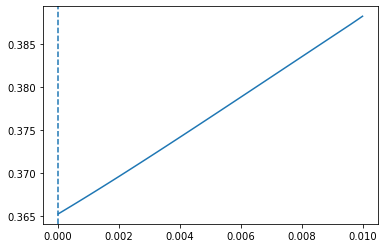

In [533]:
lamdas = np.linspace(0,0.01,50)
niter = 30
E_test = []
for lbda in lamdas : 
    flist, x ,E_test2 = forward_backward(A,y,lbda,tau,d)
    yAx = y1 * A1.dot(x)
    E_test.append(np.mean(logistic(-yAx)))
E_test = np.array(E_test)
plt.plot(lamdas,E_test)
plt.axvline (x=E_test.argmin(),linestyle='--') 
plt.show()

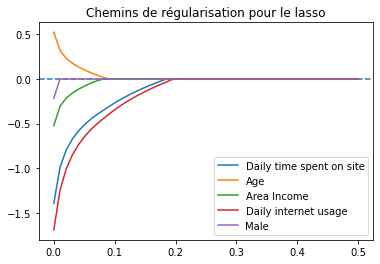

In [534]:
lamdas = np.linspace(0,0.5,50)
niter = 30
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
for lbda in lamdas:
    flist, x ,E_test2 = forward_backward(A,y,lbda,tau,d)
    x1.append(x[0])
    x2.append(x[1])
    x3.append(x[2])
    x4.append(x[3])
    x5.append(x[4])
        
plt.axhline (y=0,linestyle='--') 
plt.plot(lamdas,x1,label='Daily time spent on site')
plt.plot(lamdas,x2,label = 'Age')
plt.plot(lamdas,x3,label ='Area Income')
plt.plot(lamdas,x4,label = 'Daily internet usage')
plt.plot(lamdas,x5,label = 'Male')
plt.legend()
plt.title('Chemins de régularisation pour le lasso')
plt.show()

### RIDGE

In order to perform regularization, The
most well known method is using the $\ell^2$ norm

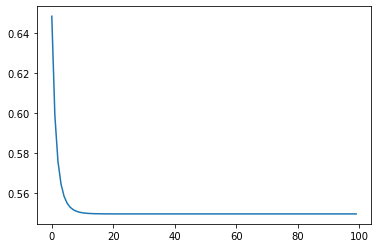

In [535]:
tau = 1/(2*L)
niter = 100
lbda = 0.1
x,cost_values1,gd = gradient_descent(A,y,tau,niter,lbda) 

plt.plot(cost_values1)
plt.show()

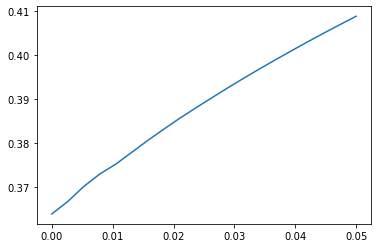

In [536]:
lamdas = np.linspace(0,0.05,20)
niter = 80
E_test = []
for lbda in lamdas : 
    x,cost_values1,gd = gradient_descent(A,y,tau,niter,lbda) 
    yAx = y1 * A1.dot(x)
    E_test.append(np.mean(logistic(-yAx)))
E_test = np.array(E_test)
plt.plot(lamdas,E_test)
# plt.axvline (x=E_test.argmin(),linestyle='--') 
plt.show()

In [58]:
## Chemins de régularisation pour Ridge

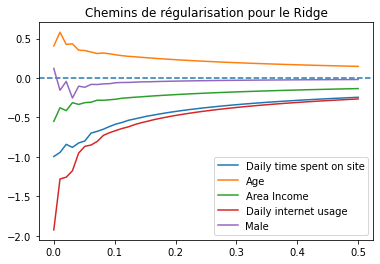

In [537]:
lamdas = np.linspace(0,0.5,50)
niter = 30
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
for lbda in lamdas:
    x,cost_values1,gd = gradient_descent(A,y,tau,niter,lbda) 
    x1.append(x[0])
    x2.append(x[1])
    x3.append(x[2])
    x4.append(x[3])
    x5.append(x[4])
        
plt.axhline (y=0,linestyle='--') 
plt.plot(lamdas,x1,label='Daily time spent on site')
plt.plot(lamdas,x2,label = 'Age')
plt.plot(lamdas,x3,label ='Area Income')
plt.plot(lamdas,x4,label = 'Daily internet usage')
plt.plot(lamdas,x5,label = 'Male')
plt.legend()
plt.title('Chemins de régularisation pour le Ridge')
plt.show()

## Newton

In [538]:
niter = 30
tau = tau_max/2
lbda = 0

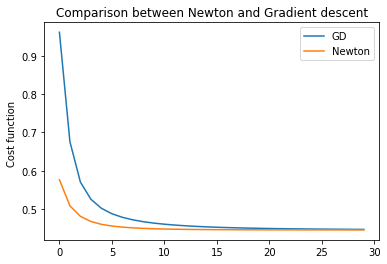

In [539]:
x, cost_values,H = Newton(A,y,niter,lbda)
x2,cost_values2,_ = gradient_descent(A,y,tau,niter,lbda)
plt.plot(range(niter),cost_values2, label='GD')
plt.plot(range(niter),cost_values,label ='Newton')

plt.ylabel('Cost function ')
plt.legend()
plt.title('Comparison between Newton and Gradient descent')
plt.show()

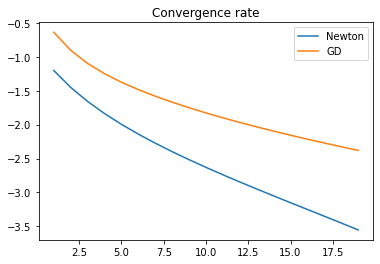

In [540]:
ndisp = 20
plt.plot(np.arange(1,ndisp), np.log10(cost_values[1:ndisp]- np.min(cost_values)), label='Newton')
plt.plot(np.arange(1,ndisp), np.log10(cost_values2[1:ndisp]- np.min(cost_values)), label='GD')
plt.legend()
plt.title('Convergence rate')
plt.show()

## svm 

Let's apply LINEAR svm on 2D data

In [541]:
A_2D = A[:,[0,3]]

In [542]:
X = A_2D

In [543]:
### FROM SCRATCH

In [544]:
class SVM:

    def __init__(self, learning_rate=0.001, lambda_param=0.0001, n_iters=100):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None


    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

The decision function value

In [293]:
def visualize_svm():
     def get_hyperplane_value(x, w, b, offset):
          return (-w[0] * x + b + offset) / w[1]

     fig = plt.figure()
     ax = fig.add_subplot(1,1,1)
     plt.scatter(X[:,0], X[:,1], marker='o',c=y)

     x0_1 = np.amin(X[:,0])
     x0_2 = np.amax(X[:,0])

     x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
     x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

     x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
     x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

     x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
     x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

     ax.plot([x0_1, x0_2],[x1_1, x1_2], 'y--')
     ax.plot([x0_1, x0_2],[x1_1_m, x1_2_m], 'k')
     ax.plot([x0_1, x0_2],[x1_1_p, x1_2_p], 'k')

     x1_min = np.amin(X[:,1])
     x1_max = np.amax(X[:,1])
     ax.set_ylim([x1_min-3,x1_max+3])
     #plt.title('C = 10000')
     plt.title('C = 10')

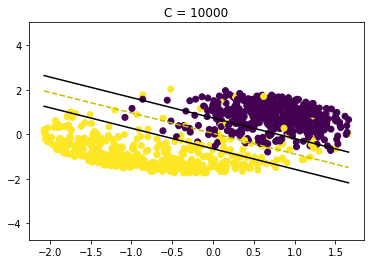

In [292]:
clf = SVM()
clf.fit(A_2D,y)
w = clf.w
b = clf.b
visualize_svm()

In [294]:
clf = SVM(lambda_param = 0.1)
clf.fit(A_2D,y)
w = clf.w
b = clf.b

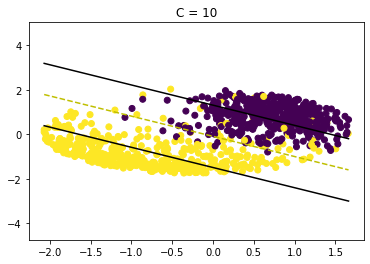

In [295]:
visualize_svm()

Cross validation for the lambda parameter

In [71]:

from sklearn.model_selection import StratifiedKFold



nb_iter = 2
C_vec = np.logspace(-8,-1,100)
perf_val = np.zeros((len(C_vec), nb_iter))
X = A
kf = StratifiedKFold(n_splits= nb_iter)
for i, (ind_a, ind_v) in enumerate(kf.split(X,y)):
    X_a,X_v = X[ind_a], X[ind_v]
    y_a, y_v = y[ind_a], y[ind_v]

    for i_C, C in enumerate(C_vec):
            clf = SVM(lambda_param = C)
            clf.fit(X_a,y_a)
            y_pred_v = clf.predict(X_v)
            perf_val[i_C,i] = np.mean(y_pred_v==y_v)

m_perf = perf_val.mean(axis = 1)
ind_max = np.unravel_index(np.argmax(m_perf), m_perf.shape)
C_opt = C_vec[ind_max[0]] 


Text(0.5, 1.0, 'accuracy w.r.t 1/C')

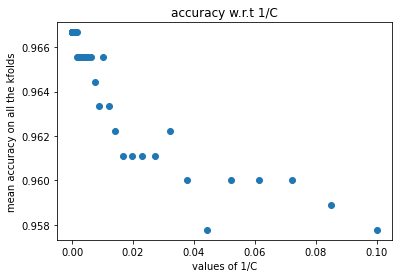

In [298]:
plt.scatter(C_vec,m_perf)
plt.ylabel('mean accuracy on all the kfolds')
plt.xlabel('values of 1/C')
plt.title('accuracy w.r.t 1/C')

In [73]:
m_perf

array([0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.96666667, 0.96666667, 0.96555

In [74]:
C_vec

array([1.00000000e-08, 1.17681195e-08, 1.38488637e-08, 1.62975083e-08,
       1.91791026e-08, 2.25701972e-08, 2.65608778e-08, 3.12571585e-08,
       3.67837977e-08, 4.32876128e-08, 5.09413801e-08, 5.99484250e-08,
       7.05480231e-08, 8.30217568e-08, 9.77009957e-08, 1.14975700e-07,
       1.35304777e-07, 1.59228279e-07, 1.87381742e-07, 2.20513074e-07,
       2.59502421e-07, 3.05385551e-07, 3.59381366e-07, 4.22924287e-07,
       4.97702356e-07, 5.85702082e-07, 6.89261210e-07, 8.11130831e-07,
       9.54548457e-07, 1.12332403e-06, 1.32194115e-06, 1.55567614e-06,
       1.83073828e-06, 2.15443469e-06, 2.53536449e-06, 2.98364724e-06,
       3.51119173e-06, 4.13201240e-06, 4.86260158e-06, 5.72236766e-06,
       6.73415066e-06, 7.92482898e-06, 9.32603347e-06, 1.09749877e-05,
       1.29154967e-05, 1.51991108e-05, 1.78864953e-05, 2.10490414e-05,
       2.47707636e-05, 2.91505306e-05, 3.43046929e-05, 4.03701726e-05,
       4.75081016e-05, 5.59081018e-05, 6.57933225e-05, 7.74263683e-05,
      

In [299]:
C_opt

1e-08

In [303]:
y1[y1==0] = -1

In [304]:
clf = SVM(lambda_param = C_opt)
clf.fit(A,y)
w = clf.w
b = clf.b
y_pred = clf.predict(A1)
Confusion = np.zeros((2,2))

Confusion[0,0] = np.sum( np.logical_and(y1 == 1,y_pred == 1))
Confusion[1,0] = np.sum( np.logical_and(y1 == -1,y_pred == 1))
Confusion[1,1] = np.sum( np.logical_and(y1 == -1,y_pred == -1))
Confusion[0,1] = np.sum( np.logical_and(y1 == 1,y_pred == -1))


print(Confusion)

[[57.  0.]
 [ 1. 42.]]


## VARIANCE reduction techniques

## SVRG 

In [545]:
lbda = 0

In [548]:
# Stochastic gradient (batch size 1) without averaging
nb_epochs = 30# SVRG
m = 10
w_output, costs = svrg(A,y,n_iter=int(nb_epochs*n/(2*m+n)),m=m)

tau = 1/(2*L)
lbda = 0
nb = 1
n = 900
n_iter=int(nb_epochs*n/nb)

x,cost_values,val_cost_values = stoch_grad(A,tau,y,lbda,nb, n_iter,scaling =0)
# w_output2, costs2 = saga(A,y, n_iter=nb_epochs*n)

SVRG


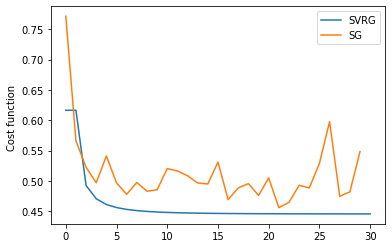

In [549]:
plt.plot(costs,label ='SVRG')
plt.plot(cost_values,label ='SG')
plt.ylabel('Cost function ')
plt.legend()

plt.show()

## SG WITH MOMENTUM

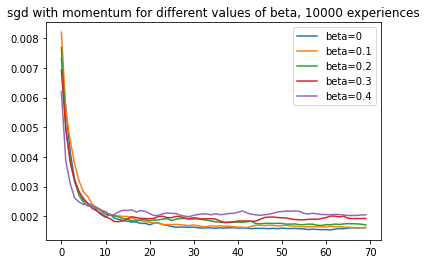

In [427]:
tau = 1/(2*L)
betas = [0,0.1,0.2,0.3,0.4]
lbda = 0
niter = 70
for beta in betas :
    all_cost_values = np.zeros((10000,70))
    for exp in range(100):
        x, cost_values, val_cost_values = momentum(A,tau,y,lbda,niter,beta)
        all_cost_values[exp,:] = cost_values
    mean_cost_values = all_cost_values.mean(axis = 0)
    plt.plot(mean_cost_values,label ='beta='+str(beta))
plt.legend()
plt.title('sgd with momentum for different values of beta, 10000 experiences')
plt.show()
